In [1]:
import os
import re
import sys
import cv2
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

sys.path.append("..")
from utils import rle2mask, combine_masks, save_masks, copy_images

<b>Read and prepare training dataframe

In [2]:
df_path = "../data/train.csv"

df = pd.read_csv(df_path)
df.head()

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...


In [3]:
# Transform class to column

df['fname'], df['cls'] = df['ImageId'], df['ClassId']
df['cls'] = df['cls'].astype(int)
df = df.pivot(index='fname',columns='cls',values='EncodedPixels')
df['defects'] = df.count(axis=1)
df = pd.DataFrame(df.to_records()).fillna("0 0")
df.head()

,fname,1,2,3,4,defects
0,0002cc93b.jpg,29102 12 29346 24 29602 24 29858 24 30114 24 3...,0 0,0 0,0 0,1
1,0007a71bf.jpg,0 0,0 0,18661 28 18863 82 19091 110 19347 110 19603 11...,0 0,1
2,000a4bcdd.jpg,37607 3 37858 8 38108 14 38359 20 38610 25 388...,0 0,0 0,0 0,1
3,000f6bf48.jpg,0 0,0 0,0 0,131973 1 132228 4 132483 6 132738 8 132993 11 ...,1
4,0014fce06.jpg,0 0,0 0,229501 11 229741 33 229981 55 230221 77 230468...,0 0,1


<b>Combine 4 classes into 1

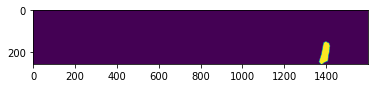

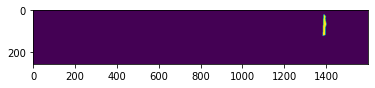

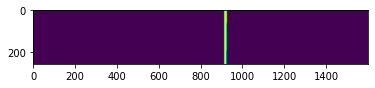

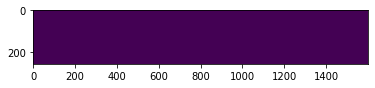

In [4]:
# all images have height = 256 and width = 1600
height = 256
width = 1600

# take one example with multiple defects
sample = df.loc[df["defects"] == 3].iloc[0]

# select rle
rle1 = sample[1]
rle2 = sample[2]
rle3 = sample[3]
rle4 = sample[4]

# create masks
mask1 = rle2mask(rle1, height, width)
mask2 = rle2mask(rle2, height, width)
mask3 = rle2mask(rle3, height, width)
mask4 = rle2mask(rle4, height, width)

masks = [mask1, mask2, mask3, mask4]

for mask in masks:
    plt.imshow(mask)
    plt.show()

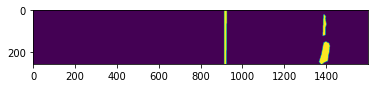

In [5]:
# combine masks
combined = 255 * (mask1 + mask2 + mask3 + mask4)
combined = combined.clip(0, 255).astype("uint8")

plt.imshow(combined)
plt.show()

(256, 1600)
(256, 1600)


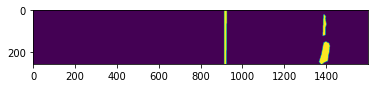

In [7]:
mask1 = rle2mask(rle1, 256, 1600)
mask2 = rle2mask(rle2, 256, 1600)
mask3 = rle2mask(rle3, 256, 1600)
mask4 = rle2mask("0 0", 256, 1600)
print(mask1.shape)

masks = [mask1, mask2, mask3, mask4]

# add masks
result = 255*(mask1 + mask2 + mask3 + mask4)
result = result.clip(0, 255).astype("uint8")
print(result.shape)

# show results
plt.imshow(result)

<b>Sample training data (we need 1000 images)

In [9]:
mult_df = df.loc[df["defects"] > 1].reset_index(drop=True)
print("Num of images with multiple defects:", len(mult_df))
mult_df.head()

Num of images with multiple defects: 427


,fname,1,2,3,4,defects
0,0025bde0c.jpg,0 0,0 0,8458 14 8707 35 8963 48 9219 71 9475 88 9731 8...,315139 8 315395 15 315651 16 315906 17 316162 ...,2
1,002fc4e19.jpg,146021 3 146275 10 146529 40 146783 46 147038 ...,145658 7 145901 20 146144 33 146386 47 146629 ...,0 0,0 0,2
2,008ef3d74.jpg,356336 4 356587 11 356838 18 357089 25 357340 ...,375439 5 375687 14 375935 24 376182 34 376430 ...,0 0,0 0,2
3,00ac8372f.jpg,101742 3 101998 12 102253 19 102301 22 102509 ...,98114 24 98370 72 98626 119 98881 168 99137 19...,0 0,0 0,2
4,00c88fed0.jpg,10474 7 10728 15 10983 18 11239 21 11494 24 11...,13428 8 13684 24 13940 39 14196 55 14452 71 14...,0 0,0 0,2


In [10]:
# drop images with multiple defects
mult_fname_list = mult_df.fname.tolist()
single_df = df.loc[~df.fname.isin(mult_fname_list), :]

# sample single defect images
single_df = single_df.sample(1000 - len(mult_df)).reset_index(drop=True)
print("Num of images with single defect:", len(single_df))
single_df.head()

Num of images with single defect: 573


,fname,1,2,3,4,defects
0,a68dcc7d2.jpg,0 0,0 0,49665 101 49921 201 50177 200 50433 200 50689 ...,0 0,1
1,409adafbe.jpg,0 0,0 0,201198 19 201418 55 201637 92 201857 128 20207...,0 0,1
2,e863b1467.jpg,0 0,0 0,92673 127 92929 253 93185 253 93441 253 93697 ...,0 0,1
3,ea5c8ec19.jpg,0 0,0 0,156196 17 156445 50 156693 85 156942 119 15719...,0 0,1
4,cf7dbc448.jpg,0 0,0 0,59905 32 60161 96 60417 160 60673 224 60929 65...,0 0,1


In [11]:
# concat two dataframes
data = pd.concat([single_df, mult_df], ignore_index=True)
print("Total num of images:", len(data))
data.head()

Total num of images: 1000


,fname,1,2,3,4,defects
0,a68dcc7d2.jpg,0 0,0 0,49665 101 49921 201 50177 200 50433 200 50689 ...,0 0,1
1,409adafbe.jpg,0 0,0 0,201198 19 201418 55 201637 92 201857 128 20207...,0 0,1
2,e863b1467.jpg,0 0,0 0,92673 127 92929 253 93185 253 93441 253 93697 ...,0 0,1
3,ea5c8ec19.jpg,0 0,0 0,156196 17 156445 50 156693 85 156942 119 15719...,0 0,1
4,cf7dbc448.jpg,0 0,0 0,59905 32 60161 96 60417 160 60673 224 60929 65...,0 0,1


<b>Save data to disk

In [14]:
defects = data["defects"]

train, test = train_test_split(data, test_size=0.1, stratify=defects)

print("Num images in train:", train.fname.nunique())
print("Num images in test:", test.fname.nunique())

train.to_csv("../data/train/train.csv", index=False)
test.to_csv("../data/test/test.csv", index=False)

Num images in train: 900
Num images in test: 100


In [15]:
train_masks_dir = "../data/train/masks"
test_masks_dir = "../data/test/masks"
os.makedirs(train_masks_dir, exist_ok=True)
os.makedirs(test_masks_dir, exist_ok=True)

save_masks(train, train_masks_dir)
save_masks(test, test_masks_dir)

In [16]:
imgs_dir = "/home/gotsul/Downloads/severstal-steel-defect-detection/train_images"
train_imgs_dir = "../data/train/images"
test_imgs_dir = "../data/test/images"
os.makedirs(train_imgs_dir, exist_ok=True)
os.makedirs(test_imgs_dir, exist_ok=True)

copy_images(train, imgs_dir, train_imgs_dir)
copy_images(test, imgs_dir, test_imgs_dir)